In [2]:
#Before execution, Try the below command and compile in command prompt.
#GCC compiler is required for preparAtion.

#cd ../../utils
#gcc -cpp -fPIC -shared lib_cvtIntegralImage45.c -lm -o lib_cvtIntegralImage45.so -O3 std=c99

In [3]:
!which python

/home/atom/miniconda3/bin/python


In [4]:
!gcc -cpp -fPIC -shared ./utils/lib_cvtIntegralImage45.c -lm -o ./utils/lib_cvtIntegralImage45.so -O3 -std=c99

In [5]:
from utils.SeparabilityFilter import *

In [6]:
import cv2
from PIL import Image
import PIL.ImageOps
from scipy import stats
import h5py

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time


import glob
import os.path as osp
from PIL import Image

def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result
def add_margin(cv_gray_img, top, right, bottom, left):
    height, width = cv_gray_img.shape
    new_width = width + right + left
    new_height = height + top + bottom
    result = np.zeros((new_height, new_width), dtype=np.uint8)
    result[top:-bottom, left:-right] = cv_gray_img
    return result

def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGRA)
    return new_image

def cv2pil(image):
    ''' OpenCV型 -> PIL型 '''
    new_image = image.copy()
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    new_image = Image.fromarray(new_image)
    return new_image

def make_datapath_list(rootpath = "./data/hymenoptera_data/"):
    """
    Returns
    -------
    path_list : list
        データへのパスを格納したリスト
    """
    target_path = osp.join(rootpath+'\\*.avi')
    print(target_path)

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list



In [9]:
X = cv2.imread('testimages/DSC_3136.JPG') # sample1.png is a gray-scale CG generated face image
X = cv2.cvtColor(X, cv2.COLOR_RGB2GRAY)
print(X.shape)
orgHeight, orgWidth = X.shape[:2]
#size = (orgHeight//2, orgWidth//2)
size = (orgWidth//10, orgHeight//10)

X = cv2.resize(X, size)
print(X.shape)

(3096, 5504)
(309, 550)


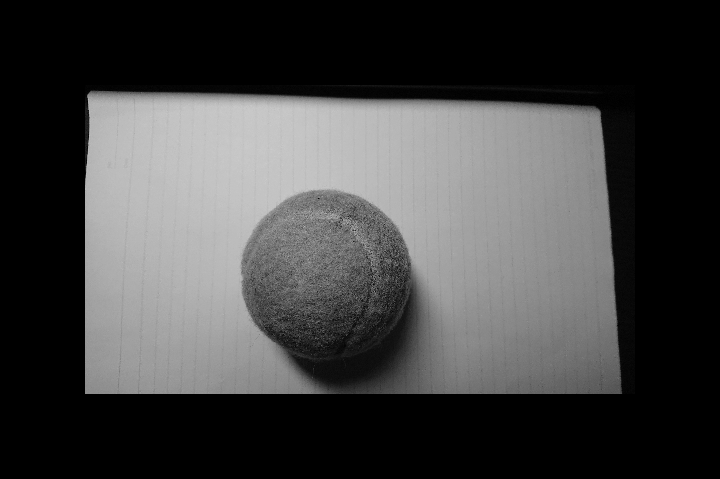

In [10]:
#x = add_margin(X, height//2, width//2, height//2, width//2)
nR = 85
x = add_margin(X, nR, nR, nR, nR)
X = x
cv2pil(x)

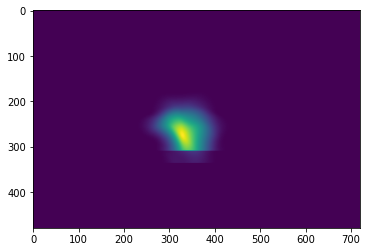

In [15]:
P.shape
plt.imshow(P.mean(axis=2))

(480, 721)


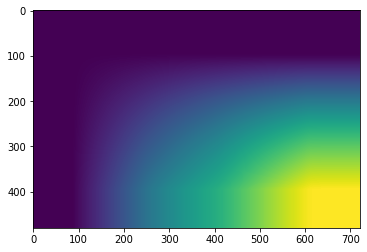

In [11]:
I1 = cvtIntegralImage(X)   
print(I1.shape)
plt.imshow(I1)

In [12]:
%%time
X = X.astype(np.float64)
H, W = X.shape
%time I1 = cvtIntegralImage(X)                 # calculate integral image
%time P1 = cvtIntegralImage(X**2)    # calculate integral image of squared pixel value
%time I2 = cvtIntegralImage45(X)               # calculate 45 degrees integral image
%time P2 = cvtIntegralImage45(X**2)  # calculate 45 degrees integral image of squared pixel value
#nR = 30      # filter size parameter
#nTH = 0.10 # threshold for finding local peaks
#nR = 30      # filter size parameter
nTH = 0.145 # threshold for finding local peaks

P = np.zeros((H,W,4), np.float64)
%time P[:,:,0:2] =  cvtCombSimpRectFilter(I1,P1,nR)   # apply vertical and horizontal rectangular filters
%time P[:,:,2:4] = cvtCombSimpRectFilter45(I2,P2,nR)   # apply vertical and horizontal rectangular filters
P[P<=0] = 0#0+1e-7
finalMap1 = stats.gmean(P[:,:,0:4]+1e-8, 2)
%time PL1 = cvtFindLocalPeakX(finalMap1,1,nTH)

CPU times: user 9.89 ms, sys: 3.68 ms, total: 13.6 ms
Wall time: 13.2 ms
CPU times: user 6.67 ms, sys: 1.65 ms, total: 8.32 ms
Wall time: 7.85 ms
CPU times: user 6.61 ms, sys: 1.75 ms, total: 8.35 ms
Wall time: 8.17 ms
CPU times: user 6.36 ms, sys: 2.61 ms, total: 8.97 ms
Wall time: 8.84 ms
CPU times: user 21.1 ms, sys: 7.01 ms, total: 28.1 ms
Wall time: 28.1 ms
CPU times: user 26 ms, sys: 2.04 ms, total: 28.1 ms
Wall time: 27.8 ms
CPU times: user 9.16 ms, sys: 0 ns, total: 9.16 ms
Wall time: 9.18 ms
CPU times: user 166 ms, sys: 30.2 ms, total: 196 ms
Wall time: 193 ms


In [20]:
np.max(finalMap1)

0.15976182946088127

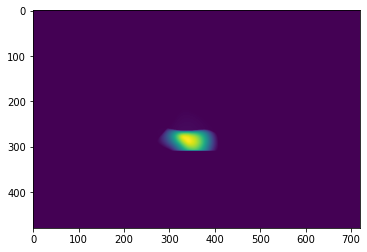

In [21]:
plt.imshow(finalMap1)

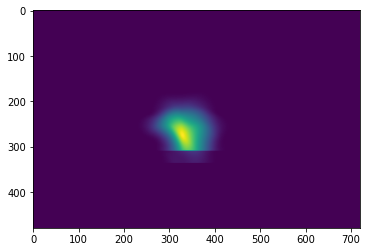

In [22]:
finalMap2 = np.mean(P[:,:,0:4], 2)
plt.imshow(finalMap2)

In [23]:
%time PL1 = cvtFindLocalPeakX(finalMap1,1,nTH)

CPU times: user 13.8 ms, sys: 5.35 ms, total: 19.2 ms
Wall time: 15.7 ms


In [24]:
PL1

array([[2.85000000e+02, 2.82000000e+02],
       [3.41000000e+02, 3.36000000e+02],
       [1.59761829e-01, 1.58797974e-01]])

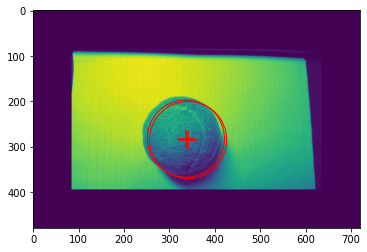

In [25]:
currentAxis = plt.gca()
for i in range(0, PL1.shape[1]):
    currentAxis.add_patch(plt.Circle(xy=(PL1[1,i], PL1[0,i]), radius=nR, fill=False, edgecolor='r', linewidth=1))
    plt.scatter(PL1[1,i], PL1[0,i], s=300, marker="+", c="r")
plt.imshow(X)

In [26]:
X = cv2.imread('testimages/DSC_3130.JPG') # sample1.png is a gray-scale CG generated face image
X = cv2.cvtColor(X, cv2.COLOR_RGB2GRAY)
print(X.shape)
orgHeight, orgWidth = X.shape[:2]
#size = (orgHeight//2, orgWidth//2)
size = (orgWidth//10, orgHeight//10)

X = cv2.resize(X, size)
print(X.shape)

(3096, 5504)
(309, 550)


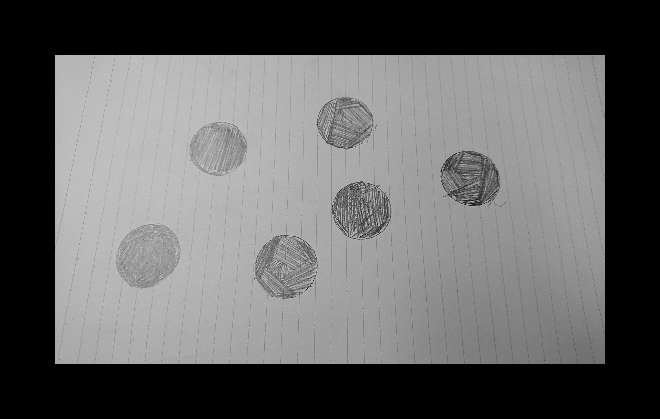

In [27]:
#x = add_margin(X, height//2, width//2, height//2, width//2)
nR = 55
x = add_margin(X, nR, nR, nR, nR)
X = x
cv2pil(x)

In [28]:
%%time
X = X.astype(np.float64)
H, W = X.shape
%time I1 = cvtIntegralImage(X)                 # calculate integral image
%time P1 = cvtIntegralImage(np.power(X, 2))    # calculate integral image of squared pixel value
%time I2 = cvtIntegralImage45(X)               # calculate 45 degrees integral image
%time P2 = cvtIntegralImage45(np.power(X, 2))  # calculate 45 degrees integral image of squared pixel value
#nR = 30      # filter size parameter
#nTH = 0.10 # threshold for finding local peaks
nR = 30      # filter size parameter
nTH = 0.40 # threshold for finding local peaks

P = np.zeros((H,W,4), np.float64)
%time P[:,:,0:2] =  cvtCombSimpRectFilter(I1,P1,nR)   # apply vertical and horizontal rectangular filters
%time P[:,:,2:4] = cvtCombSimpRectFilter45(I2,P2,nR)   # apply vertical and horizontal rectangular filters
P[P<=0] = 0#0+1e-7
finalMap1 = stats.gmean(P[:,:,0:4]+1e-8, 2)
%time PL1 = cvtFindLocalPeakX(finalMap1,1,nTH)

CPU times: user 8.69 ms, sys: 160 µs, total: 8.85 ms
Wall time: 7.92 ms
CPU times: user 13.7 ms, sys: 0 ns, total: 13.7 ms
Wall time: 13.2 ms
CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 9.94 ms
CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 14.6 ms
CPU times: user 44.8 ms, sys: 4.54 ms, total: 49.3 ms
Wall time: 49.4 ms
CPU times: user 48 ms, sys: 256 µs, total: 48.2 ms
Wall time: 50 ms
CPU times: user 19.6 ms, sys: 0 ns, total: 19.6 ms
Wall time: 19.6 ms
CPU times: user 250 ms, sys: 8.13 ms, total: 258 ms
Wall time: 255 ms


In [29]:
np.max(finalMap1)

0.6039687436552589

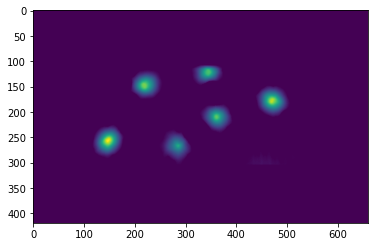

In [30]:
plt.imshow(finalMap1)

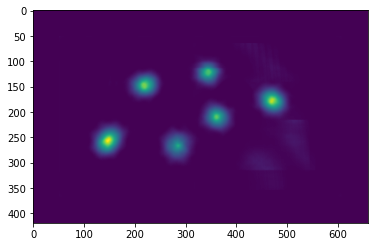

In [31]:
finalMap2 = np.mean(P[:,:,0:4], 2)
plt.imshow(finalMap2)

In [32]:
%time PL1 = cvtFindLocalPeakX(finalMap1,1,nTH)

CPU times: user 21.1 ms, sys: 4.79 ms, total: 25.9 ms
Wall time: 20.4 ms


In [33]:
PL1

array([[2.56000000e+02, 1.79000000e+02, 1.47000000e+02, 2.09000000e+02,
        1.22000000e+02],
       [1.48000000e+02, 4.70000000e+02, 2.20000000e+02, 3.61000000e+02,
        3.46000000e+02],
       [6.03968744e-01, 5.47527560e-01, 4.81420413e-01, 4.54567338e-01,
        4.33542069e-01]])

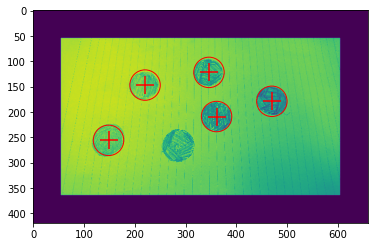

In [34]:
currentAxis = plt.gca()
for i in range(0, PL1.shape[1]):
    currentAxis.add_patch(plt.Circle(xy=(PL1[1,i], PL1[0,i]), radius=nR, fill=False, edgecolor='r', linewidth=1))
    plt.scatter(PL1[1,i], PL1[0,i], s=300, marker="+", c="r")
plt.imshow(X)

In [35]:
X = cv2.imread('testimages/DSC_3137.JPG') # sample1.png is a gray-scale CG generated face image
X = cv2.cvtColor(X, cv2.COLOR_RGB2GRAY)
print(X.shape)
orgHeight, orgWidth = X.shape[:2]
#size = (orgHeight//2, orgWidth//2)
size = (orgWidth//10, orgHeight//10)

X = cv2.resize(X, size)
print(X.shape)

(3096, 5504)
(309, 550)


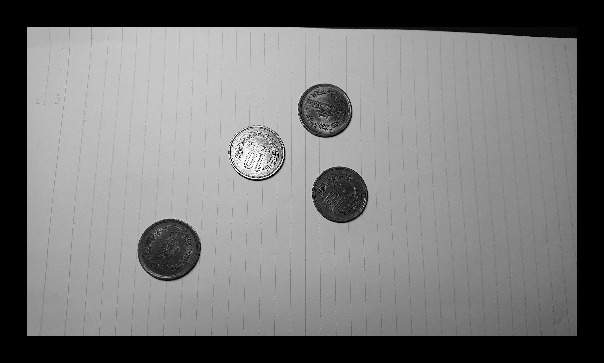

In [36]:
#x = add_margin(X, height//2, width//2, height//2, width//2)
nR = 27
x = add_margin(X, nR, nR, nR, nR)
X = x
cv2pil(x)

In [37]:
%%time
X = X.astype(np.float64)
H, W = X.shape
%time I1 = cvtIntegralImage(X)                 # calculate integral image
%time P1 = cvtIntegralImage(np.power(X, 2))    # calculate integral image of squared pixel value
%time I2 = cvtIntegralImage45(X)               # calculate 45 degrees integral image
%time P2 = cvtIntegralImage45(np.power(X, 2))  # calculate 45 degrees integral image of squared pixel value
#nR = 30      # filter size parameter
#nTH = 0.10 # threshold for finding local peaks
#nR = 50      # filter size parameter
nTH = 0.50 # threshold for finding local peaks

P = np.zeros((H,W,4), np.float64)
%time P[:,:,0:2] =  cvtCombSimpRectFilter(I1,P1,nR)   # apply vertical and horizontal rectangular filters
%time P[:,:,2:4] = cvtCombSimpRectFilter45(I2,P2,nR)   # apply vertical and horizontal rectangular filters
P[P<=0] = 0#0+1e-7
finalMap1 = stats.gmean(P[:,:,0:4]+1e-8, 2)
%time PL1 = cvtFindLocalPeakX(finalMap1,1,nTH)

CPU times: user 7.21 ms, sys: 537 µs, total: 7.74 ms
Wall time: 7.42 ms
CPU times: user 9.89 ms, sys: 809 µs, total: 10.7 ms
Wall time: 10.6 ms
CPU times: user 6.55 ms, sys: 2.22 ms, total: 8.77 ms
Wall time: 8.42 ms
CPU times: user 10.8 ms, sys: 739 µs, total: 11.5 ms
Wall time: 11.2 ms
CPU times: user 33.3 ms, sys: 12 ms, total: 45.3 ms
Wall time: 45.3 ms
CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 39.3 ms
CPU times: user 17.6 ms, sys: 0 ns, total: 17.6 ms
Wall time: 17.1 ms
CPU times: user 191 ms, sys: 25.6 ms, total: 217 ms
Wall time: 213 ms


In [38]:
np.max(finalMap1)

0.8713181430081117

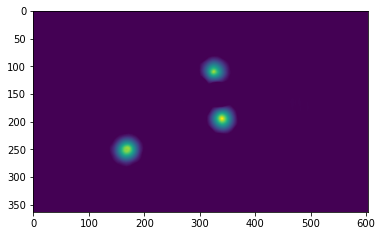

In [39]:
plt.imshow(finalMap1)

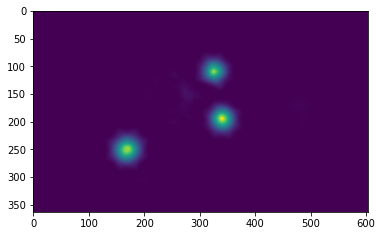

In [40]:
finalMap2 = np.mean(P[:,:,0:4], 2)
plt.imshow(finalMap2)

In [41]:
%time PL1 = cvtFindLocalPeakX(finalMap1,1,nTH)

CPU times: user 16.5 ms, sys: 11.6 ms, total: 28.1 ms
Wall time: 20.7 ms


In [42]:
PL1

array([[194.        , 110.        , 247.        , 252.        ],
       [340.        , 325.        , 170.        , 170.        ],
       [  0.87131814,   0.75270054,   0.73529905,   0.72714822]])

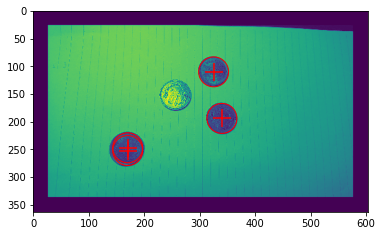

In [43]:
currentAxis = plt.gca()
for i in range(0, PL1.shape[1]):
    currentAxis.add_patch(plt.Circle(xy=(PL1[1,i], PL1[0,i]), radius=nR, fill=False, edgecolor='r', linewidth=1))
    plt.scatter(PL1[1,i], PL1[0,i], s=300, marker="+", c="r")
plt.imshow(X)